# MODELOS DE REDES PARA DENGUE BARRANCABERMEJA

### Cargue de librerias requeridas

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

### Cargar la base de datos

In [2]:
datos = read_csv('Barrancabermeja_Lags.csv', encoding='latin-1', sep=";")

# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi',
       'Temp_Seca_Max_Dia_Prom', 'Temp_Seca_Max_Dia_Prom_1',
       'Temp_Seca_Max_Dia_Prom_2', 'Temp_Seca_Max_Dia_Prom_3',
       'Temp_Seca_Max_Dia_Prom_4', 'Temp_Seca_Max_Dia_Prom_5',
       'Temp_Seca_Max_Dia_Prom_6', 'Temp_Seca_Max_Sem', 'Temp_Seca_Max_Sem_1',
       'Temp_Seca_Max_Sem_2', 'Temp_Seca_Max_Sem_3', 'Temp_Seca_Max_Sem_4',
       'Temp_Seca_Max_Sem_5', 'Temp_Seca_Max_Sem_6', 'Temp_Seca_Min_Dia_Prom',
       'Temp_Seca_Min_Dia_Prom_1', 'Temp_Seca_Min_Dia_Prom_4',
       'Temp_Seca_Min_Dia_Prom_5', 'Temp_Seca_Min_Sem', 'Temp_Seca_Min_Sem_1', 'Temp_Seca_Min_Sem_2',
       'Temp_Seca_Min_Sem_3', 'Temp_Seca_Min_Sem_4', 'Temp_Seca_Min_Sem_5',
       'Temp_Seca_Min_Sem_6', 'Prom_Dia_Preci',
       'Prom_Dia_Preci_2', 'Prom_Dia_Preci_1', 'Prom_Dia_Preci_3',
       'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6', 'Total_Preci_Sem',
        'Total_Preci_Sem_2', 'Total_Preci_Sem_1',
       'Total_Preci_Sem_3', 'Total_Preci_Sem_5', 'Total_Preci_Sem_6',
       'Temp_Max_Dia_Prom', 'Temp_Max_Dia_Prom_1', 'Temp_Max_Dia_Prom_2',
       'Temp_Max_Dia_Prom_3', 'Temp_Max_Dia_Prom_4', 'Temp_Max_Dia_Prom_5',
       'Temp_Max_Dia_Prom_6', 'Temp_Max_Sem', 'Temp_Max_Sem_1',
       'Temp_Max_Sem_2', 'Temp_Max_Sem_3', 'Temp_Max_Sem_4', 'Temp_Max_Sem_5',
       'Temp_Max_Sem_6', 'Temp_Min_Dia_Prom', 'Temp_Min_Dia_Prom_1',
       'Temp_Min_Dia_Prom_2', 'Temp_Min_Dia_Prom_3', 'Temp_Min_Dia_Prom_4',
       'Temp_Min_Dia_Prom_5', 'Temp_Min_Dia_Prom_6', 'Temp_Min_Sem',
       'Temp_Min_Sem_1', 'Temp_Min_Sem_2', 'Temp_Min_Sem_3', 'Temp_Min_Sem_4',
       'Temp_Min_Sem_5', 'Temp_Min_Sem_6', 'Hum_Rel_Max', 'Hum_Rel_Max_1',
       'Hum_Rel_Max_2', 'Hum_Rel_Max_3', 'Hum_Rel_Max_4', 'Hum_Rel_Max_5',
       'Hum_Rel_Max_6','Hum_Rel_Min_1', 'Hum_Rel_Min_2',
       'Hum_Rel_Min_3', 'Hum_Rel_Min_5','Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_6',
                    'Hum_Rel_Min', 'Hum_Rel_Min_6','Temp_Seca_Min_Dia_Prom_2', 'Hum_Rel_Min_4',  ],axis=1)
datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_4', 'Total_Preci_Sem_4'], dtype='object')

In [3]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_4     0
Total_Preci_Sem_4    0
dtype: int64

### División de los datos en set de entrenamiento y prueba

In [4]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [5]:
f_columns = ['Prom_Dia_Preci_4', 'Total_Preci_Sem_4']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [6]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# MODELO LSTM

In [8]:
# Creación de X_train, y_train, X_test y y_test Para el modelo LSTM

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_LSTM, y_train_LSTM = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_LSTM, y_test_LSTM = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_LSTM.shape, y_train_LSTM.shape, X_test_LSTM.shape, y_test_LSTM.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo LSTM

In [9]:
Preci_Barr_LSTM_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Preci_Barr_LSTM_model_1.add(keras.layers.InputLayer(input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    
#CAPAS INTERMEDIAS

Preci_Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Preci_Barr_LSTM_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Preci_Barr_LSTM_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Preci_Barr_LSTM_model_4.h5'
checkpoint_LSTM = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_LSTM = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_LSTM = Preci_Barr_LSTM_model_1.fit(X_train_LSTM,y_train_LSTM, validation_data=(X_test_LSTM,y_test_LSTM), 
                                     verbose=2, epochs=100, callbacks=[monitor_LSTM, checkpoint_LSTM])
Preci_Barr_LSTM_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 13s - loss: 0.0696 - mse: 0.0696 - val_loss: 0.0208 - val_mse: 0.0208 - 13s/epoch - 915ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0109 - val_mse: 0.0109 - 439ms/epoch - 31ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0076 - val_mse: 0.0076 - 424ms/epoch - 30ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0051 - val_mse: 0.0051 - 446ms/epoch - 32ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0047 - val_mse: 0.0047 - 474ms/epoch - 34ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0052 - val_mse: 0.0052 - 499ms/epoch - 36ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0048 - val_mse: 0.0048 - 423ms/epoch - 30ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0044 - val_mse: 0.0044 - 490ms/epoch - 35ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0055 - val_mse

# MODELO CNN

In [10]:
# Creación de X_train, y_train, X_test y y_test Para el modelo CNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_CNN, y_train_CNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_CNN, y_test_CNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_CNN.shape, y_train_CNN.shape, X_test_CNN.shape, y_test_CNN.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo CNN

In [11]:
Preci_Barr_CNN_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Preci_Barr_CNN_model_1.add(keras.layers.InputLayer(input_shape=(X_train_CNN.shape[1], X_train_CNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Preci_Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Preci_Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Preci_Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Preci_Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Preci_Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Preci_Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Preci_Barr_CNN_model_1.add(Dropout(0.5))
Preci_Barr_CNN_model_1.add(Flatten())
    
Preci_Barr_CNN_model_1.add(keras.layers.Dense(units=256, activation='linear'))
Preci_Barr_CNN_model_1.add(Dropout(0.5)) 


#CAPA DE SALIDA                 
Preci_Barr_CNN_model_1.add(Dense(1))


#COMPILACIÓN DEL MODELO
Preci_Barr_CNN_model_1.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Preci_Barr_CNN_model_4.h5'
checkpoint_CNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_CNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_CNN = Preci_Barr_CNN_model_1.fit(X_train_CNN,y_train_CNN, validation_data=(X_test_CNN,y_test_CNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_CNN, checkpoint_CNN])
Preci_Barr_CNN_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 2s - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0044 - val_mse: 0.0044 - 2s/epoch - 128ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0031 - val_mse: 0.0031 - 212ms/epoch - 15ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0056 - val_mse: 0.0056 - 135ms/epoch - 10ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0035 - val_mse: 0.0035 - 125ms/epoch - 9ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0080 - val_mse: 0.0080 - 125ms/epoch - 9ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0025 - val_mse: 0.0025 - 157ms/epoch - 11ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0052 - val_mse: 0.0052 - 128ms/epoch - 9ms/step


# MODELO RNN

In [12]:
# Creación de X_train, y_train, X_test y y_test Para el modelo RNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_RNN, y_train_RNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_RNN, y_test_RNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo RNN

In [13]:
Preci_Barr_RNN_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Preci_Barr_RNN_model_1.add(keras.layers.InputLayer(input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Preci_Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Preci_Barr_RNN_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Preci_Barr_RNN_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Preci_Barr_RNN_model_4.h5'
checkpoint_RNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_RNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_RNN = Preci_Barr_RNN_model_1.fit(X_train_RNN,y_train_RNN, validation_data=(X_test_RNN,y_test_RNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_RNN, checkpoint_RNN])
Preci_Barr_RNN_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 6s - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0109 - val_mse: 0.0109 - 6s/epoch - 447ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0060 - val_mse: 0.0060 - 314ms/epoch - 22ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0048 - val_mse: 0.0048 - 283ms/epoch - 20ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0049 - val_mse: 0.0049 - 204ms/epoch - 15ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0058 - val_mse: 0.0058 - 204ms/epoch - 15ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0083 - val_mse: 0.0083 - 204ms/epoch - 15ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0037 - val_mse: 0.0037 - 235ms/epoch - 17ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0039 - val_mse: 0.0039 - 211ms/epoch - 15ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0072 - val_mse: 

# MODELO GRU

In [14]:
# Creación de X_train, y_train, X_test y y_test Para el modelo GRU

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_GRU, y_train_GRU = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_GRU, y_test_GRU = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_GRU.shape, y_train_GRU.shape, X_test_GRU.shape, y_test_GRU.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo GRU

In [15]:
Preci_Barr_GRU_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Preci_Barr_GRU_model_1.add(keras.layers.InputLayer(input_shape=(X_train_GRU.shape[1], X_train_GRU.shape[2])))
    
    
#CAPAS INTERMEDIAS

Preci_Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Preci_Barr_GRU_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Preci_Barr_GRU_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Preci_Barr_GRU_model_4.h5'
checkpoint_GRU = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_GRU = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_GRU = Preci_Barr_GRU_model_1.fit(X_train_GRU,y_train_GRU, validation_data=(X_test_GRU,y_test_GRU), 
                                     verbose=2, epochs=100, callbacks=[monitor_GRU, checkpoint_GRU])
Preci_Barr_GRU_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 12s - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0062 - val_mse: 0.0062 - 12s/epoch - 861ms/step
Epoch 2/100
14/14 - 1s - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0053 - val_mse: 0.0053 - 609ms/epoch - 44ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0093 - val_mse: 0.0093 - 360ms/epoch - 26ms/step
Epoch 4/100
14/14 - 1s - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0039 - val_mse: 0.0039 - 533ms/epoch - 38ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0037 - val_mse: 0.0037 - 491ms/epoch - 35ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0047 - val_mse: 0.0047 - 361ms/epoch - 26ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0081 - val_mse: 0.0081 - 361ms/epoch - 26ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0085 - val_mse: 0.0085 - 417ms/epoch - 30ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0050 - val_mse

### Graficas de función de pérdida & RMSE

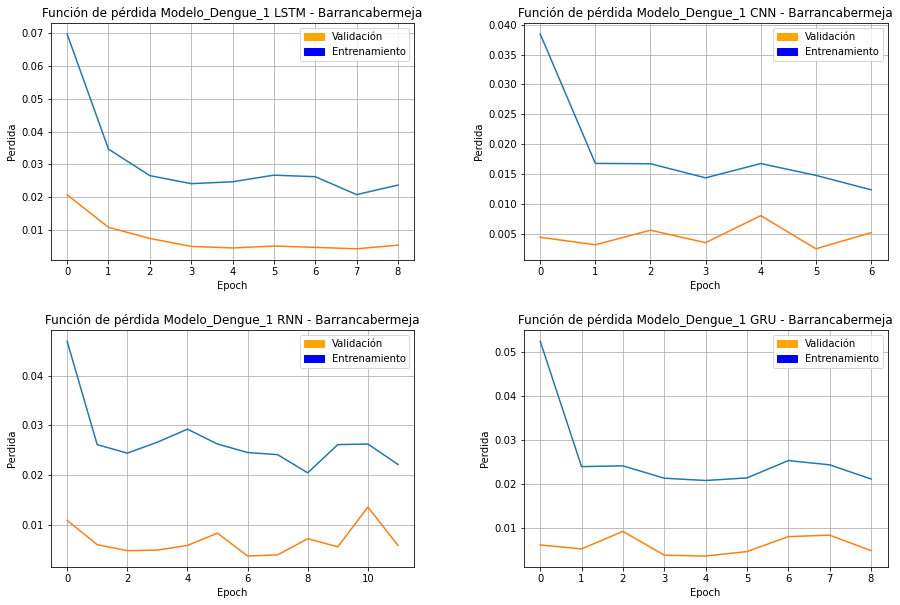

In [16]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 LSTM - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

plt.subplot(2, 2, 2)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 CNN - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])

plt.subplot(2, 2, 3)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 RNN - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])

plt.subplot(2, 2, 4)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 GRU - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])

plt.show()

# Gráficas de dispersión

6/6 [==============================] - 2s 6ms/step


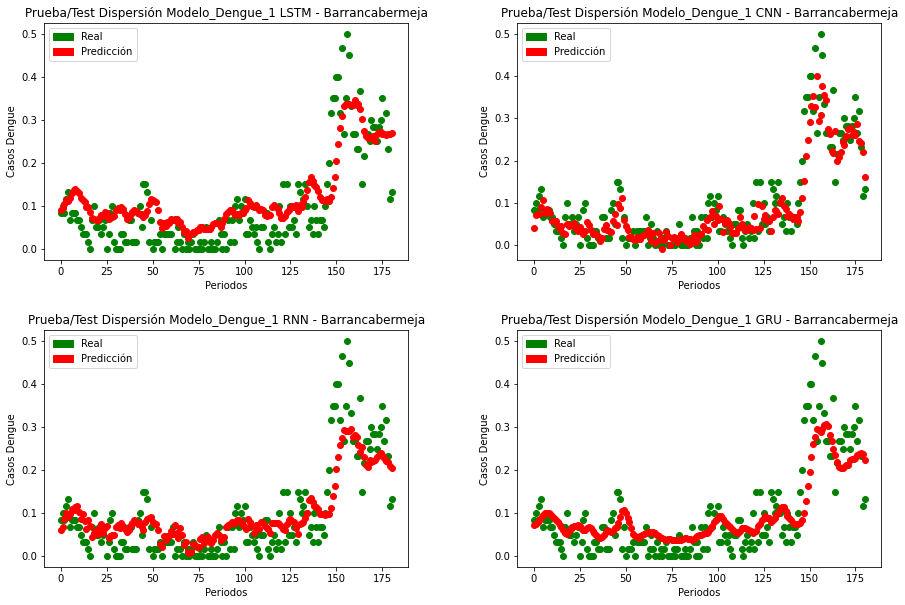

In [17]:
results_LSTM =Preci_Barr_LSTM_model_1.predict(X_test_LSTM)
results_CNN =Preci_Barr_CNN_model_1.predict(X_test_CNN)
results_RNN =Preci_Barr_RNN_model_1.predict(X_test_RNN)
results_GRU =Preci_Barr_GRU_model_1.predict(X_test_GRU)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 LSTM - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_LSTM)),y_test_LSTM,c='g')
plt.scatter(range(len(results_LSTM)),results_LSTM,c='r')

plt.subplot(2, 2, 2)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 CNN - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_CNN)),y_test_CNN,c='g')
plt.scatter(range(len(results_CNN)),results_CNN,c='r')

plt.subplot(2, 2, 3)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 RNN - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_RNN)),y_test_RNN,c='g')
plt.scatter(range(len(results_RNN)),results_RNN,c='r')

plt.subplot(2, 2, 4)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 GRU - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_GRU)),y_test_GRU,c='g')
plt.scatter(range(len(results_GRU)),results_GRU,c='r')

plt.show()

In [18]:
y_pred_LSTM = Preci_Barr_LSTM_model_1.predict(X_test_LSTM)
y_pred_CNN = Preci_Barr_CNN_model_1.predict(X_test_CNN)
y_pred_RNN = Preci_Barr_RNN_model_1.predict(X_test_RNN)
y_pred_GRU = Preci_Barr_GRU_model_1.predict(X_test_GRU)

y_train_inv_LSTM = dengue_transformer.inverse_transform(y_train_LSTM.reshape(1, -1))
y_train_inv_CNN = dengue_transformer.inverse_transform(y_train_CNN.reshape(1, -1))
y_train_inv_RNN = dengue_transformer.inverse_transform(y_train_RNN.reshape(1, -1))
y_train_inv_GRU = dengue_transformer.inverse_transform(y_train_GRU.reshape(1, -1))

y_test_inv_LSTM = dengue_transformer.inverse_transform(y_test_LSTM.reshape(1, -1))
y_test_inv_CNN = dengue_transformer.inverse_transform(y_test_CNN.reshape(1, -1))
y_test_inv_RNN = dengue_transformer.inverse_transform(y_test_RNN.reshape(1, -1))
y_test_inv_GRU = dengue_transformer.inverse_transform(y_test_GRU.reshape(1, -1))

y_pred_inv_LSTM = dengue_transformer.inverse_transform(y_pred_LSTM)
y_pred_inv_CNN = dengue_transformer.inverse_transform(y_pred_CNN)
y_pred_inv_RNN = dengue_transformer.inverse_transform(y_pred_RNN)
y_pred_inv_GRU = dengue_transformer.inverse_transform(y_pred_GRU)

6/6 [==============================] - 0s 13ms/step


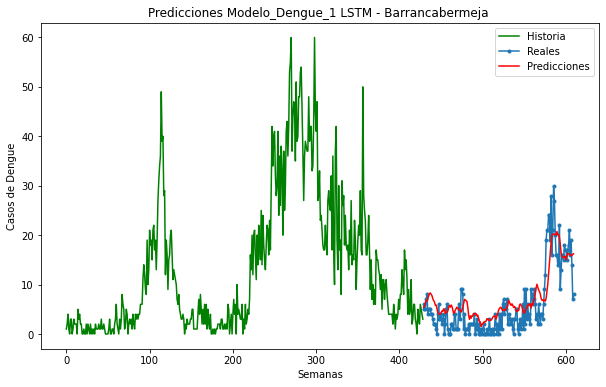

In [19]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_LSTM)), y_train_inv_LSTM.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_test_inv_LSTM.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_pred_inv_LSTM.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 LSTM - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

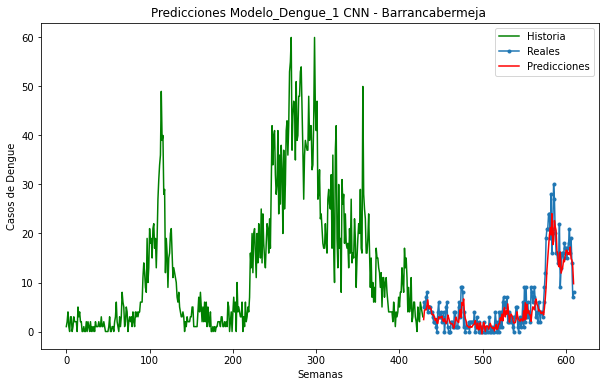

In [20]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_CNN)), y_train_inv_CNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_test_inv_CNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_pred_inv_CNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 CNN - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

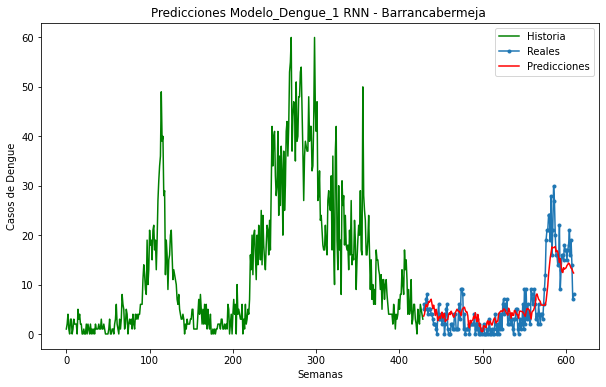

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_RNN)), y_train_inv_RNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_test_inv_RNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_pred_inv_RNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 RNN - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

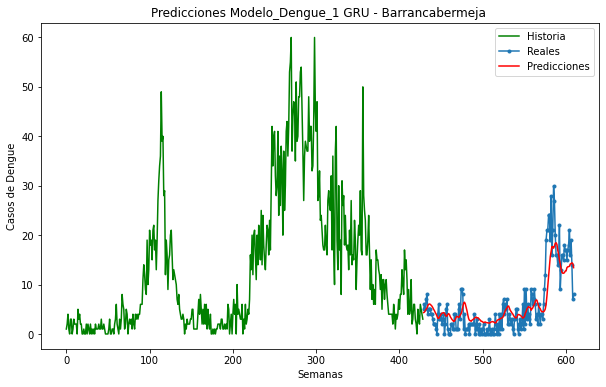

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_GRU)), y_train_inv_GRU.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_test_inv_GRU.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_pred_inv_GRU.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 GRU - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

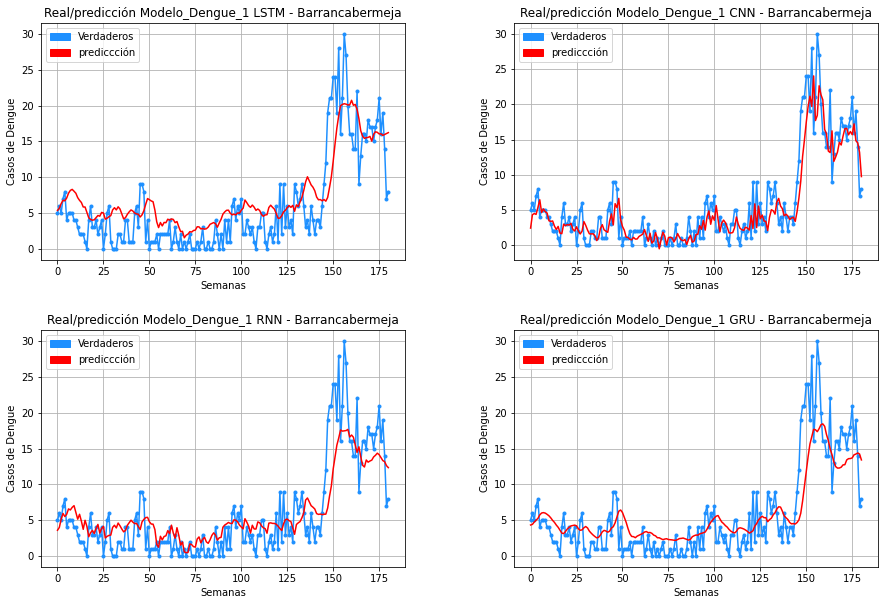

In [23]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Real/predicción Modelo_Dengue_1 LSTM - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_LSTM.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_LSTM.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Real/predicción Modelo_Dengue_1 CNN - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_CNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_CNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Real/predicción Modelo_Dengue_1 RNN - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_RNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_RNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Real/predicción Modelo_Dengue_1 GRU - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_GRU.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_GRU.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.show()

In [24]:
score_LSTM = np.sqrt(metrics.mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
score_CNN = np.sqrt(metrics.mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
score_RNN = np.sqrt(metrics.mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
score_GRU = np.sqrt(metrics.mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

print("RMSE Modelo LSTM Dengue Barranca : {}".format(score_LSTM))
print("RMSE Modelo CNN Dengue Barranca  : {}".format(score_CNN))
print("RMSE Modelo RNN Dengue Barranca  : {}".format(score_RNN))
print("RMSE Modelo GRU Dengue Barranca  : {}".format(score_GRU))

RMSE Modelo LSTM Dengue Barranca : 3.9807000985122927
RMSE Modelo CNN Dengue Barranca  : 2.9744447033785866
RMSE Modelo RNN Dengue Barranca  : 3.647551696443996
RMSE Modelo GRU Dengue Barranca  : 3.6618643233700783


In [25]:
print("MSE Modelo LSTM Dengue Barranca  = ", mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MSE Modelo CNN Dengue Barranca   = ", mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MSE Modelo RNN Dengue Barranca   = ", mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MSE Modelo GRU Dengue Barranca   = ", mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MSE Modelo LSTM Dengue Barranca  =  15.845973274295776
MSE Modelo CNN Dengue Barranca   =  8.847321293456929
MSE Modelo RNN Dengue Barranca   =  13.304633378231472
MSE Modelo GRU Dengue Barranca   =  13.4092503227706


In [26]:
print("MAE Modelo LSTM Dengue Barranca = ", mean_absolute_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MAE Modelo CNN Dengue Barranca  = ", mean_absolute_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MAE Modelo RNN Dengue Barranca  = ", mean_absolute_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MAE Modelo GRU Dengue Barranca  = ", mean_absolute_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MAE Modelo LSTM Dengue Barranca =  3.15896828925412
MAE Modelo CNN Dengue Barranca  =  2.1485803895912943
MAE Modelo RNN Dengue Barranca  =  2.7235332049058947
MAE Modelo GRU Dengue Barranca  =  2.7417721498078405


In [27]:
print("r2_score Modelo LSTM Dengue Barranca  = ", r2_score(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("r2_score Modelo CNN Dengue Barranca  = ", r2_score(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("r2_score Modelo RNN Dengue Barranca  = ", r2_score(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("r2_score Modelo GRU Dengue Barranca  = ", r2_score(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

r2_score Modelo LSTM Dengue Barranca  =  0.6365242134439751
r2_score Modelo CNN Dengue Barranca  =  0.7970596687002149
r2_score Modelo RNN Dengue Barranca  =  0.6948176045559346
r2_score Modelo GRU Dengue Barranca  =  0.692417895459799


In [28]:
print("explained_variance_score Modelo LSTM Dengue Barranca  = ", explained_variance_score(y_test_inv_LSTM.flatten(), 
                                                                                           y_pred_inv_LSTM.flatten()))
print("explained_variance_score Modelo CNN Dengue Barranca  = ", explained_variance_score(y_test_inv_CNN.flatten(), 
                                                                                           y_pred_inv_CNN.flatten()))
print("explained_variance_score Modelo RNN Dengue Barranca  = ", explained_variance_score(y_test_inv_RNN.flatten(), 
                                                                                           y_pred_inv_RNN.flatten()))
print("explained_variance_score Modelo GRU Dengue Barranca  = ", explained_variance_score(y_test_inv_GRU.flatten(), 
                                                                                           y_test_inv_GRU.flatten()))

explained_variance_score Modelo LSTM Dengue Barranca  =  0.6835529839518231
explained_variance_score Modelo CNN Dengue Barranca  =  0.8061389386021507
explained_variance_score Modelo RNN Dengue Barranca  =  0.6950420701205999
explained_variance_score Modelo GRU Dengue Barranca  =  1.0


### VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

In [29]:
#MODELO LSTM
resultados_LSTM = pd.DataFrame({ 'Actuales':y_test_inv_LSTM.flatten(), 'Predicciones': y_pred_inv_LSTM.flatten()})
resultados_LSTM['diferencia'] = resultados_LSTM['Predicciones'] - resultados_LSTM['Actuales']
print(resultados_LSTM.head(5))
print(resultados_LSTM.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      5.356252    0.356252
1       6.0      5.652498   -0.347502
2       5.0      6.310200    1.310200
3       7.0      6.776456   -0.223544
4       8.0      6.706796   -1.293204
     Actuales  Predicciones  diferencia
176      16.0     16.050007    0.050007
177      19.0     15.834448   -3.165552
178      14.0     15.965971    1.965971
179       7.0     16.083887    9.083887
180       8.0     16.221722    8.221722


In [30]:
#MODELO CNN
resultados_CNN = pd.DataFrame({ 'Actuales':y_test_inv_CNN.flatten(), 'Predicciones': y_pred_inv_CNN.flatten()})
resultados_CNN['diferencia'] = resultados_CNN['Predicciones'] - resultados_CNN['Actuales']
print(resultados_CNN.head(5))
print(resultados_CNN.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      2.436638   -2.563362
1       6.0      4.340195   -1.659805
2       5.0      4.501681   -0.498319
3       7.0      4.379645   -2.620355
4       8.0      5.379114   -2.620886
     Actuales  Predicciones  diferencia
176      16.0     17.232950    1.232950
177      19.0     14.846952   -4.153048
178      14.0     14.531512    0.531512
179       7.0     13.184541    6.184541
180       8.0      9.751913    1.751913


In [31]:
#MODELO RNN
resultados_RNN = pd.DataFrame({ 'Actuales':y_test_inv_RNN.flatten(), 'Predicciones': y_pred_inv_RNN.flatten()})
resultados_RNN['diferencia'] = resultados_RNN['Predicciones'] - resultados_RNN['Actuales']
print(resultados_RNN.head(5))
print(resultados_RNN.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      3.602584   -1.397416
1       6.0      3.997732   -2.002268
2       5.0      5.152750    0.152750
3       7.0      5.948134   -1.051866
4       8.0      5.514772   -2.485228
     Actuales  Predicciones  diferencia
176      16.0     13.744585   -2.255415
177      19.0     13.334600   -5.665400
178      14.0     13.177644   -0.822356
179       7.0     12.623702    5.623702
180       8.0     12.345191    4.345191


In [32]:
#MODELO GRU
resultados_GRU = pd.DataFrame({ 'Actuales':y_test_inv_GRU.flatten(), 'Predicciones': y_pred_inv_GRU.flatten()})
resultados_GRU['diferencia'] = resultados_GRU['Predicciones'] - resultados_GRU['Actuales']
print(resultados_GRU.head(5))
print(resultados_GRU.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      4.337138   -0.662862
1       6.0      4.422945   -1.577055
2       5.0      4.754994   -0.245006
3       7.0      5.010812   -1.989188
4       8.0      5.262061   -2.737939
     Actuales  Predicciones  diferencia
176      16.0     14.142337   -1.857663
177      19.0     14.238549   -4.761451
178      14.0     14.395225    0.395225
179       7.0     14.244343    7.244343
180       8.0     13.423231    5.423231
